# PROJET : Implémenter un modèle de scoring (Partie 2)

**Autor** : Louis BIRENHOLZ   
**Date** : 04/05/2020  
**Durée totale** : 110 heures  
**Vidéo de mon projet** : https://www.youtube.com/watch?v=RLGKGFu-9aE&feature=emb_title

## Partie 2 : Classification & Custom Metric

Ce notebook présente la phase de teste des modèles de **classification**. On cherchera à trouver le modèle le plus adapté à notre problèmatique métier.

**Pour cela, on testera 3 algorithmes :**
- Régression Logisitique (baseline)
- Random Forest Classifier
- LightGBM

On comparera entre autre nos résultats via une **custom metric** adaptée à notre problème.
La construction de cette métrique est détaillée plus loin dans le notebook.

Enfin, on cherchera à interpréter notre modèle pour le rendre **"White box"** pour l'utilisateur. On utilisera des librairies pour comprendre l'importance des features et séléctioner les features pertinentes pour les visualisations sur notre dashboard.

Le dashboard est réalisé via Streamlit et a été déployé sur **Heroku**, il est visible ici : https://dashboard-credits-app.herokuapp.com/

Pour utiliser ce dashboard il est important d'avoir les **ID_client** disponibles dans le readme.txt sur mon github : https://github.com/Louis-bir/dashboard-project-credits.app

## Librairies

In [33]:
# Classic Lib.
import pandas as pd
import numpy as np

# Viz lib.
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Classification.
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.over_sampling import SMOTE

# Quality metrics.
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# XAI.
import lime
#import shap
#import lime.lime_tabular

# Others.
import pickle5 as pickle
from collections import Counter

## Settings

In [9]:
# Format & option.
sns.set(rc={'figure.figsize':(14,12)})
pd.options.display.max_columns = 150
sns.set_context("notebook", 
                font_scale=1.5, 
                rc={"lines.linewidth": 2.5})

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Data

In [11]:
# Import processed data.
df_train_imputed = pd.read_csv("/Users/louisbirenholz/Documents/Project/Python Project/Projet-Scoring-CustomMetric/Data/Processed Data/df_train_imputed.csv")
df_train_imputed.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     1.0           0.0          0.001512    0.090287     0.088688   
1     1.0           0.0          0.000742    0.233456     0.097968   
2     1.0           0.0          0.001512    0.286787     0.129025   
3     1.0           0.0          0.000935    0.060892     0.055716   
4     1.0           0.0          0.000473    0.051685     0.049213   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         0.076404                    0.256321    0.898410       0.955469   
1         0.164045                    0.245631    0.370634       0.845348   
2         0.202247                    0.344429    0.441399       0.920900   
3         0.048315                    0.097136    0.674890       0.791753   
4         0.051685                    0.392880    0.024785       0.745179   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           0.852140         0.676385     0.930873         1.0   
1           0.733585         0.721111     0.931116         1.0   
2           0.952091         0.842925     0.928352         1.0   
3           0.998176         0.326973     0.931235         1.0   
4           0.781493         0.359029     0.930730         1.0   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0             1.0              0.0               1.0         1.0         0.0   
1             1.0              0.0               1.0         0.0         0.0   
2             1.0              0.0               1.0         0.0         0.0   
3             1.0              1.0               1.0         1.0         0.0   
4             0.0              0.0               1.0         0.0         0.0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0         0.000000                   0.5                          0.5   
1         0.000000                   1.0                          0.5   
2         0.052632                   0.5                          0.5   
3         0.052632                   1.0                          1.0   
4         0.052632                   0.5                          0.5   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                 0.434783                         0.0   
1                 0.391304                         0.0   
2                 0.391304                         0.0   
3                 0.478261                         0.0   
4                 0.434783                         0.0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.072094      0.307542      0.713181        0.024700          0.059933   
1      0.596142      0.641494      0.732639        0.016500          0.032602   
2      0.565058      0.358878      0.781713        0.130900          0.145926   
3      0.478392      0.788542      0.811854        0.116394          0.108334   
4      0.795907      0.028014      0.933638        0.117185          0.110169   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                     0.972200         0.619200        0.

# Classification

Dans cette partie on testera différent modèle de classification pour voir quel est le plus adapté à notre problème.
Le coeur du problème réside dans le déséquilibre des **TARGET**. On comparera une approche après **under sampling** et **over sampling** (Avec SMOTE).

### On utilisera les métriques suivantes:
- `Accuracy_score` : % d'individu bien classé (c'est la justesse de la prédiction).
- `Precision` : Quelle proportion de classification positive était correct ?
- `Recall` : Quelle proportion de positif ont été correctement identifié ?
- `F1_score` : Synthèse de Precision et Recall
- `AUC` : Aire sous la courbe ROC.
- `Matrice de confusion`
- `ROC Curve`

### Définition d'une métrique "métier"

Dans cette partie, on cherche à créer **une métrique pertinente** concernant notre problématique.
On se place dans un contexte d'une société de crédit qui cherche à **"maximiser"** ses gains. Par exemple, accorder un crédit à quelqu'un ne pouvant pas le rembourser par la suite **(Faux négatif)** est synonyme de perte pour l'entreprise. Au contraire accorder un crédit à un client qui le rembrousera par la suite **(Vrai négatif)** est un gain.

On cherche à `pondérer` les différents cas de figure possibles **(TP, TN, FP, FN)** pour créer en score. Ce score doit prendre en compte l'aspet gain/perte du problème.

En moyenne, le montant des crédits des clients ne pouvant pas être remboursés s'éleve à **557k €**. (Et celui des clients classés 0 à 602k€). En partant du postulat que les taux d'emprunt sont de 2,6%, l'entreprise gagnera **12k€** par client remboursant le crédit.

**On pondère de la manière suivante (en prenant encompte les pertes et gains pour l'entreprise):**
- TP : 0
- TN : +12
- FP : 0
- FN : -557

`(Finalement après test et création de la custom metric, ces poids n'étaient pas adaptés. J'ai donc séléctionné les poids suivant : TN : 2 et FN : -10)`

On calcul ensuite un score normalisé entre 0 et 1 de la manière suivante: **(score - baseline) / (best - baseline)**.
Avec `best` étant le meilleur classifieur possible (on ne se trompe jamais) et `baseline` un classifieur naïf.

## Fonction utiles

Ensemble des fonctions utilisées dans ce notebook.

In [12]:
def quality(y_test, y_prediction, y_prediction_proba):
    
    """
    Cette fonction retourne différentes mesures de qualité pour la prédiction effectuée
    """
    
    # Justesse.
    accuracy = accuracy_score(y_test, y_prediction)
    
    # Precision 
    precision = precision_score(y_test, y_prediction)
    
    # Recall.
    recall = recall_score(y_test, y_prediction)
    
    # F1 score.
    F1 = f1_score(y_test, y_prediction)
    
    # AUC score.
    AUC = roc_auc_score(y_test, y_prediction_proba)
    
    # Print des métriques.
    print('Accuracy : {}'.format(accuracy))
    print('Precision : {}'.format(precision))
    print('Recall : {}'.format(recall))
    print('Score F1 : {}'.format(F1))
    print('AUC score : {}'.format(AUC))

In [13]:
def confusion_matrix(y_test, y_prediction):
    
    """
    Cette fonction retourne une matrice de confusion.
    """
    
    # Création de la matrice de confusion.
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative','Predicted Positive'], 
                                        index=['Real Negative','Real Positive'])

    # DataFrame de comparaison.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']
    
    # Masque suivant les tp,tn, fp...
    mask_real_pos = (df_pred_compare['Real category']==1)
    mask_pred_pos = (df_pred_compare['Prediction']==1)

    mask_real_neg = (df_pred_compare['Real category']==0)
    mask_pred_neg = (df_pred_compare['Prediction']==0)
    
    # Négatif.
    true_negative = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Positif.
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice.
    df_matrice_confusion['Predicted Negative'] = ["{} (TN)".format(true_negative), "{} (FN)".format(false_negative)]
    df_matrice_confusion['Predicted Positive'] = ["{} (FP)".format(false_positive), "{} (TP)".format(true_positive)]
    
    return df_matrice_confusion

In [14]:
def list_sampled(A):
    
    """
    Cette fonction divise la taille d'une liste par 3.
    """

    new_A = []

    for i,j in enumerate(A):
        if(i%3==0):
            new_A.append(j)
    
    return new_A

In [15]:
def proba_seuil(liste_proba, seuil):

    """
    Cette fonction classe un individu dans la classe positive suivant un seuil donné en entrée.
    """
    
    classe = []
    
    for i in liste_proba:
        if i>=seuil:
            classe.append(1)
        else:
            classe.append(0)
            
    return classe

In [16]:
def custom_metric(y_test, y_prediction):
    
    # Score avec un classifieur aléatoire.
    baseline = 11136
    
    # Score avec le meilleur classifieur.
    best = 97512
    
    # Calcul du nombre de TN & FN.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']
    
    mask1 = (df_pred_compare['Real category']==1)
    mask2 = (df_pred_compare['Prediction']==0)
    mask3 = (df_pred_compare['Real category']==0)
    
    TN = df_pred_compare[mask2 & mask3].shape[0]
    FN = df_pred_compare[mask1 & mask2].shape[0]
    
    # Calcul du score du classifieur.
    score = 2*TN + (-10)*FN
    
    return (score-baseline)/(best-baseline)

In [17]:
def score_seuil(prob_pos):

    my_score = []
    
    # Parcours des seuils.
    for i in np.arange(0.0001,1.1,0.025):

        predd = proba_seuil(prob_pos, i)

        my_score.append(custom_metric(Y_validation, predd))
    
    return my_score

In [18]:
def viz_p7(y_test, y_pred_proba, model_name):
    
    """
    Cette fonction retourne une visualisation ROC CURVE aisni qu'une viz du score construit en fonction du 
    seuil de classification
    """
    
    # Calcul des taux et des seuils.
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred_proba)
    
    plt.figure(figsize = (24, 18))
    
    # Premier subplot.
    plt.subplot(2, 2, 1)
    
    plt.title('ROC Curve', weight='bold', size=20)
    
    plt.plot(list_sampled(false_positive_rate),
                 list_sampled(true_positive_rate), label="{}".format(model_name))
    
    # Noms des axes
    plt.xlabel('Taux de faux positifs', size=16, weight='bold')
    plt.ylabel('Taux de vrais postifis', size=16, weight='bold')
    
    # Affichage de la légende.
    plt.legend(loc="lower right")
    
    # Deuxième subplot.
    plt.subplot(2,2,2)
    
    plt.title("Score 'métier' en fonction du seuil", weight='bold', size=20)
    plt.xlabel('Treshold', size=16, weight='bold')
    plt.ylabel('Score', size=16, weight='bold')
    sns.lineplot(np.arange(0.0001,1.1,0.025), score_seuil(y_pred_proba), color = 'blue', marker='o')

# 1) Avec Undersampling

On teste les performances des algos suivant `(LR, RF, LGBM)` sur la dataset déséquilibré.
On précisera **class_weight='balanced'** pour certains algos afin de corriger le problème de déséquilibre des classes.

In [20]:
# Split in training/testing set.
X_train, X_test, Y_train, Y_test = train_test_split(df_train_imputed.iloc[:,1:], 
                                                    df_train_imputed['TARGET'], 
                                                    test_size=0.25,
                                                    random_state=0)

In [21]:
# Split in training/validation set.
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, 
                                                                Y_train, 
                                                                test_size=0.25,
                                                                random_state=0)

In [23]:
# Count of targets.
sorted(Counter(Y_test).items())

[(0.0, 40803), (1.0, 6097)]

## A first baseline: Logistic Regression

In [36]:
# Define LR and params.
log_reg = LogisticRegression(max_iter=1000, solver='saga')
params = {'C' : np.logspace(-2, 2, 4)}

# Gridsearch & Crossvalidation.
grid_search_lr_undersampled = GridSearchCV(log_reg, params, cv=5, n_jobs=-1)

# Fit sur les données d'entrainement.
grid_search_lr_undersampled.fit(X_train, Y_train)

In [398]:
# Probabilité d'appartenance à la classe 1 (positif).
y_prob_lr_u = grid_search_lr_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

# Prédiciton.
y_pred_lr_u = grid_search_lr_undersampled.best_estimator_.predict(X_validation)

### Mesures de qualité

In [399]:
# Matrice de confusion.
confusion_matrix(Y_validation, y_pred_lr_u)

Predicted Negative Predicted Positive
Real Negative         29766 (TN)           753 (FP)
Real Positive          2852 (FN)          1804 (TP)

In [400]:
# Indices de qualité.
quality(Y_validation, y_pred_lr_u, y_prob_lr_u)

Accuracy : 0.8975124378109453
Precision : 0.7055142745404771
Recall : 0.38745704467353953
Score F1 : 0.500207957853875
AUC score : 0.8412085891173195


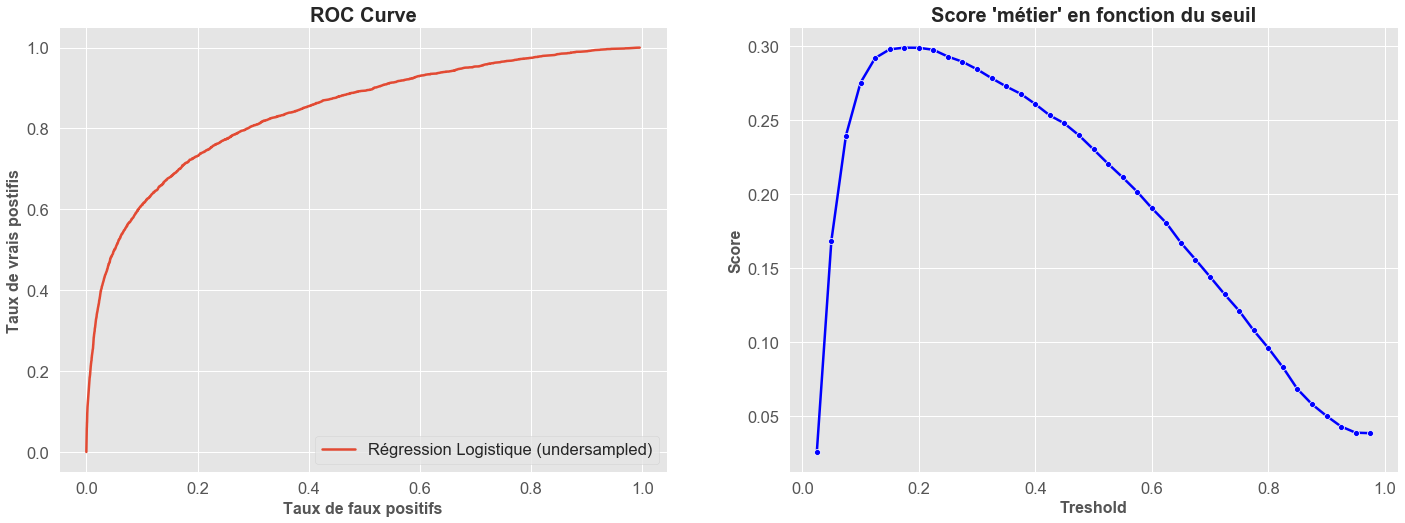

In [401]:
viz_p7(Y_validation, y_prob_lr_u, "Régression Logistique (undersampled)")

# RandomForestClassifier

In [402]:
# Random Forest Classifieur.
rForestClassifier = RandomForestClassifier(class_weight='balanced')

# GridSearch.
gridSearch_rf_undersampled = GridSearchCV(rForestClassifier, {'max_depth': range(6,10),
                                              'min_samples_leaf' : [1,2,3]},
                                               scoring='roc_auc',
                                               cv=4)

# Fit sur les données d'entrainement.
gridSearch_rf_undersampled.fit(X_train, Y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [409]:
# Prédiction.
y_pred_rf_u = gridSearch_rf_undersampled.best_estimator_.predict(X_validation)

# Proba d'appartenance à la classe 1.
y_prob_rf_u = gridSearch_rf_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

In [410]:
# Matrice de confusion.
confusion_matrix(Y_validation, y_pred_rf_u)

Predicted Negative Predicted Positive
Real Negative         27288 (TN)          3231 (FP)
Real Positive          1713 (FN)          2943 (TP)

In [411]:
# Indice de qualité.
quality(Y_validation, y_pred_rf_u, y_prob_rf_u)

Accuracy : 0.8594456289978678
Precision : 0.47667638483965014
Recall : 0.6320876288659794
Score F1 : 0.5434903047091413
AUC score : 0.8578103252449689


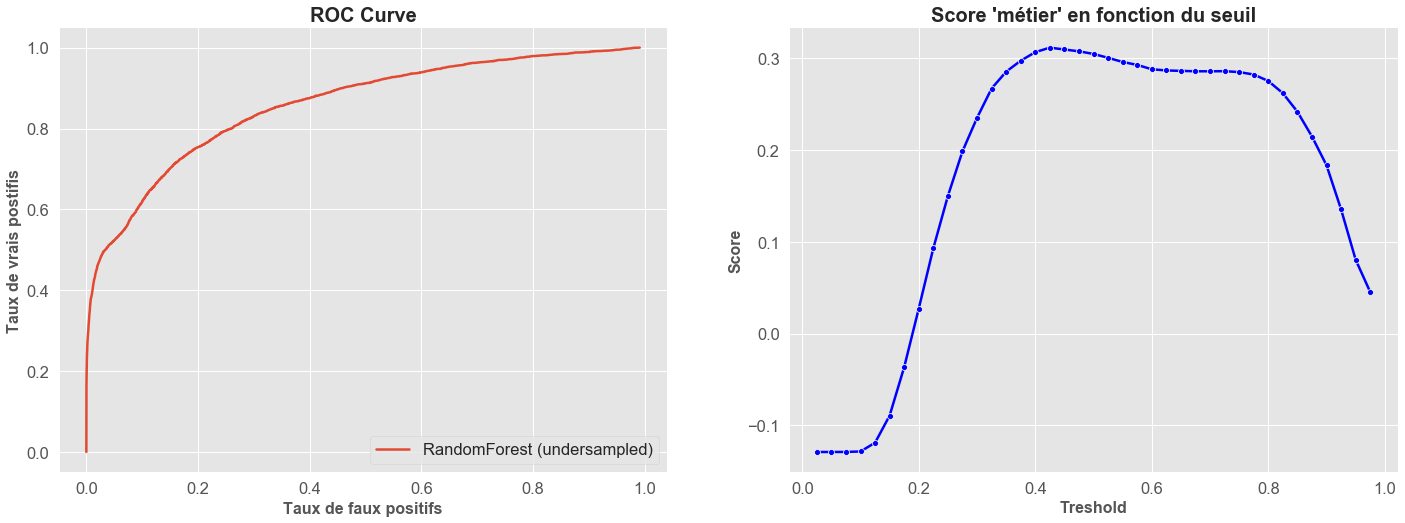

In [412]:
viz_p7(Y_validation, y_prob_rf_u, "RandomForest (undersampled)")

# LGBM

In [16]:
# Features names for LGBM.
df_train_imputed.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_train_imputed.columns]
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]

In [17]:
# LGBMClassifier.
# On utilise class_weight = 'balanced' de sorte à réduire le pb de déséquilibrage des classes 0 et 1.
lgbm = lgb.LGBMClassifier(objective='binary', 
                          class_weight='balanced',
                          reg_lambda=0.1, 
                          subsample=0.8,
                          n_jobs=-1)

In [18]:
# Paramètres pour la GridSearch.
params_lbgm = {'n_estimators' : [1000,2000],
              'learning_rate' : [1,0.1,0.01]}

# Gridsearch & Crossvalidation.
grid_search_lgbm_undersampled = GridSearchCV(lgbm, params_lbgm, cv=4)

# Fit sur les données d'entrainement.
grid_search_lgbm_undersampled.fit(X_train, Y_train,
                                  eval_metric='auc')

GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.1,
                                      silent=True, subsample=0.8,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
        

In [38]:
# Prediction.
y_pred_lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict(X_validation)

# Proba prédite.
y_prob__lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

In [39]:
# Matrice de confusion.
confusion_matrix(Y_validation, y_pred_lgbm_u)

Predicted Negative Predicted Positive
Real Negative         30067 (TN)           452 (FP)
Real Positive          1610 (FN)          3046 (TP)

In [40]:
quality(Y_validation, y_pred_lgbm_u, y_prob__lgbm_u)

Accuracy : 0.9413788201847904
Precision : 0.8707833047455689
Recall : 0.6542096219931272
Score F1 : 0.7471179789060584
AUC score : 0.9080024257324237


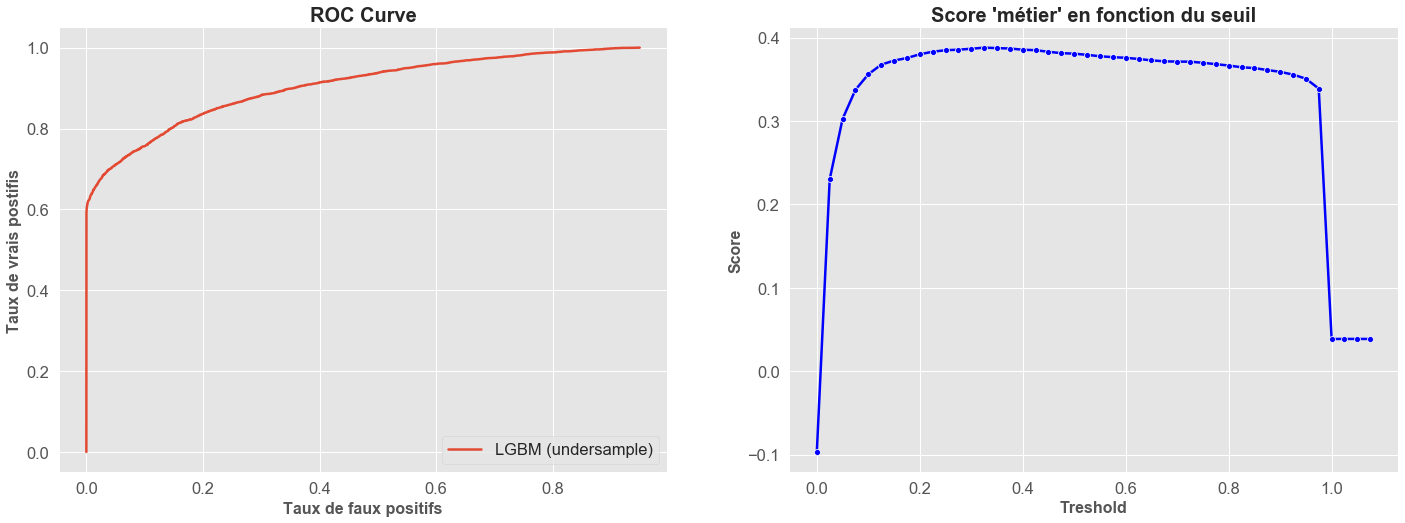

In [46]:
viz_p7(Y_validation, y_prob__lgbm_u, "LGBM (undersample)")

In [41]:
# Prédiction et check de la custom metric sur le testing set

# Proba prédite.
y_test__lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict_proba(X_test)[:,1]

In [45]:
custom_metric(Y_test, proba_seuil(y_test__lgbm_u, 0.23))

0.5674492914698528

# 2) Avec OverSampling  (SMOTE)

**SMOTE** = "Synthetic Minority Oversampling Technique"

Dans cette partie, on séléctionne l'algo nous ayant donnée les meilleurs résultats précédemment **(LGBM)** mais nous essayons une approche d'oversampling pour faire un comparatif.

**L'Oversampling** consiste à venir "doper" la classe minoritaire pour résoudre le problème de déséquilibre. On crée alors des individus artificiels pour équilibrer les classes.
On accordera un soin particulier à oversampler seulement le jeu d'entrainement. 

In [16]:
# Oversampling du jeu d'entrainement.
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, Y_train)

In [18]:
# Check de l'équilibrage des classes sur le jeu d'entrainement.
sorted(Counter(y_train_resampled).items())

[(0.0, 91452), (1.0, 91452)]

In [19]:
# LGBMClassifier.
lgbm = lgb.LGBMClassifier(objective='binary', 
                          reg_lambda=0.1, 
                          subsample=0.8,
                          n_jobs=-1)

In [20]:
# Paramètres pour la GridSearch.
params_lbgm = {'n_estimators' : [1000,2000],
              'learning_rate' : [1,0.1,0.01]}

# Gridsearch & Crossvalidation.
grid_search_lgbm_oversampled = GridSearchCV(lgbm, params_lbgm, cv=4)

# Fit sur les données d'entrainement.
grid_search_lgbm_oversampled.fit(X_train_resampled, 
                                 y_train_resampled,
                                 eval_metric='auc')

GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.1,
                                      silent=True, subsample=0.8,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [1, 0.1, 0

In [23]:
pred_resampled = grid_search_lgbm_oversampled.best_estimator_.predict(X_validation)
pred_proba_resampled = grid_search_lgbm_oversampled.best_estimator_.predict_proba(X_validation)[:,1]

In [24]:
# Matrice de confusion.
confusion_matrix(Y_validation, pred_resampled)

Predicted Negative Predicted Positive
Real Negative         30402 (TN)           117 (FP)
Real Positive          1971 (FN)          2685 (TP)

In [28]:
quality(Y_validation, pred_resampled, pred_proba_resampled)

Accuracy : 0.9406396588486141
Precision : 0.9582441113490364
Recall : 0.5766752577319587
Score F1 : 0.7200321802091714
AUC score : 0.8986859307069034


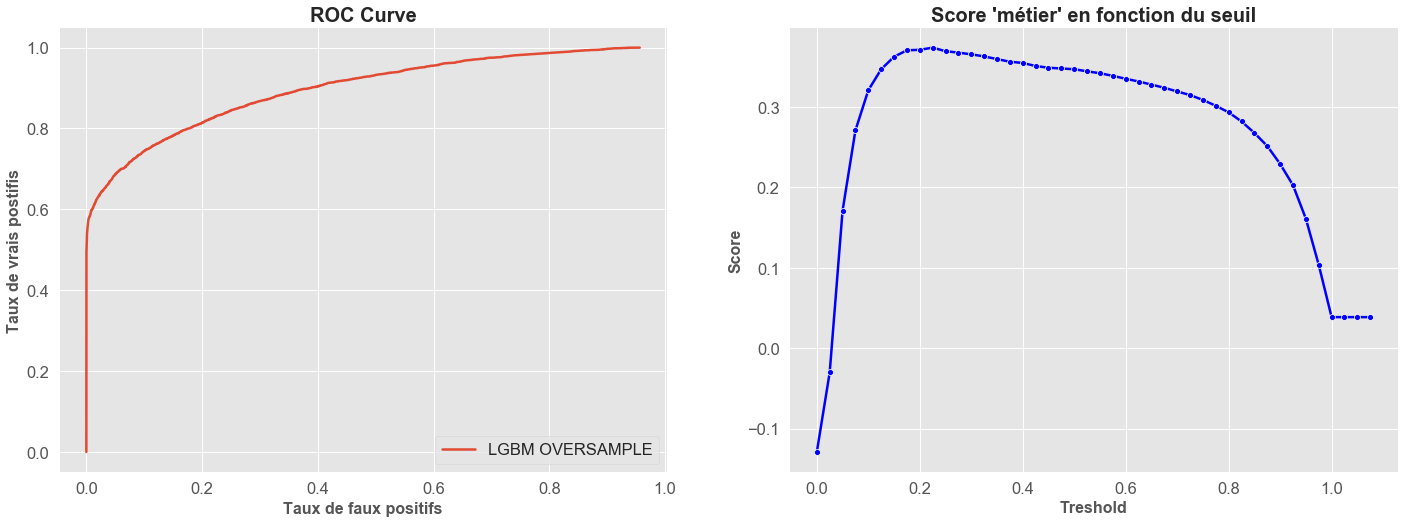

In [39]:
viz_p7(Y_validation, pred_proba_resampled, 'LGBM OVERSAMPLE')

#  Visualisation ROC Curve & Custom metric 

# 1) ROC Curve (undersample)

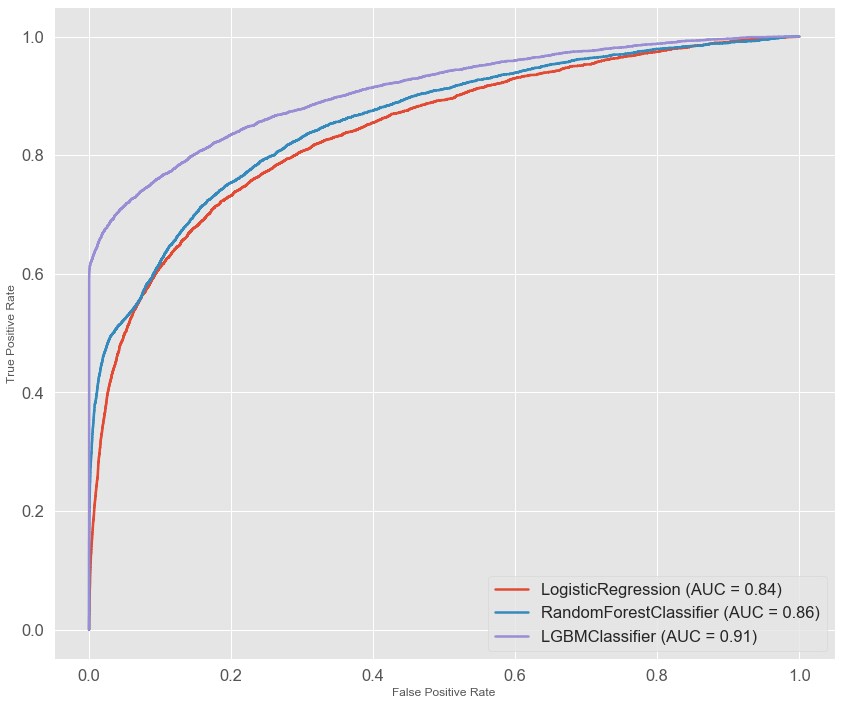

In [432]:
disp = plot_roc_curve(grid_search_lr_undersampled.best_estimator_, X_validation, Y_validation)

plot_roc_curve(gridSearch_rf_undersampled.best_estimator_, X_validation, Y_validation, ax=disp.ax_)
plot_roc_curve(grid_search_lgbm_undersampled.best_estimator_, X_validation, Y_validation, ax=disp.ax_)

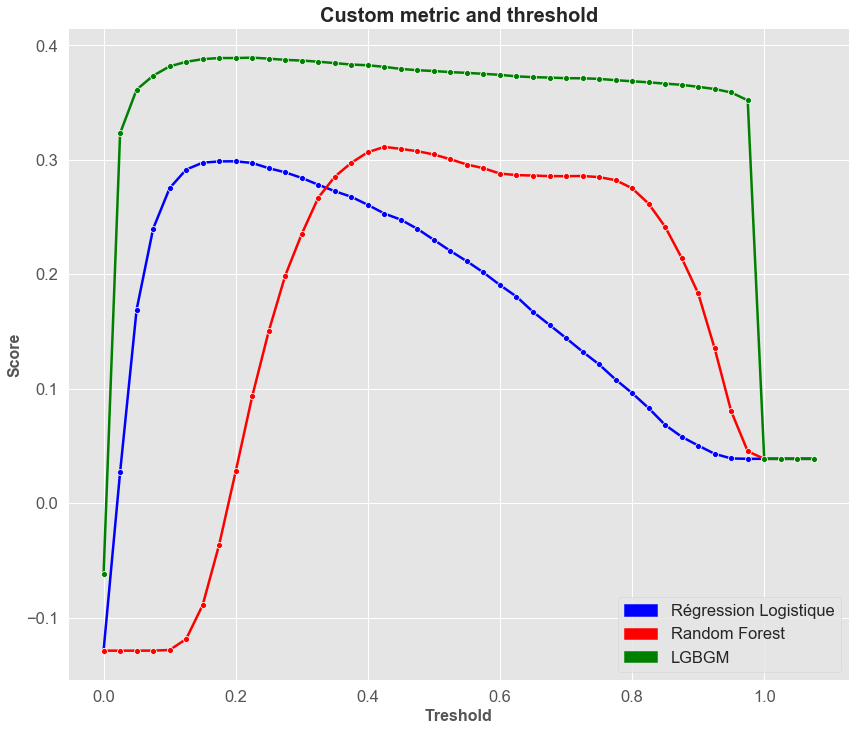

In [453]:
plt.title("Custom metric and threshold", weight='bold', size=20)
plt.xlabel('Treshold', size=16, weight='bold')
plt.ylabel('Score', size=16, weight='bold')

# Lineplot.
sns.lineplot(np.arange(0.0001,1.1,0.025), score_seuil(y_prob_lr_u), color = 'blue', marker='o')
sns.lineplot(np.arange(0.0001,1.1,0.025), score_seuil(y_prob_rf_u), color = 'red', marker='o')
sns.lineplot(np.arange(0.0001,1.1,0.025), score_seuil(y_prob__lgbm_u), color = 'green', marker='o')

# Légendes.
patch1 = mpatches.Patch(color='blue', label='Régression Logistique')
patch2 = mpatches.Patch(color='red', label='Random Forest')
patch3 = mpatches.Patch(color='green', label='LGBGM')
plt.legend(handles=[patch1,patch2,patch3])

# Check des perfs sur le Test Set

- **Algo séléctionné :** LGBM 
- **Treshold séléctionné :** 0.23

In [24]:
# Pred & Proba sur le Test Set.
y_test_prob__lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict_proba(X_test)[:,1]
y_test_pred__lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict(X_test)

In [23]:
# Check de la valeur de la custom metric.
custom_metric(Y_test, proba_seuil(y_test__lgbm_u, 0.23))

0.5674492914698528

In [25]:
quality(Y_test, y_test_pred__lgbm_u, y_test_prob__lgbm_u)

Accuracy : 0.9454584221748401
Precision : 0.8827601124810729
Recall : 0.669345579793341
Score F1 : 0.7613805970149254
AUC score : 0.9107676314181105


# Model Explanation with LIME & SHAP

Enfin, on cherche à expliquer notre modèle et checker l'importance des features.
En effet, cette analyse est cruciale pour nous orienter sur des features qui **pèsent** beaucoup lors de la classification pour notre dashboard.

On utilisera la libraire **LIME** qui utilise le voisinage de l'individus étudié et la libraire **SHAP** qui utilise la théorie des jeux.

## 1) Explanation with LIME

In [69]:
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names=X_train.columns,
                                                   class_names=['Non Défaillant','Défaillant'],
                                                   kernel_width=5)

In [70]:
predict_fn_rf = lambda x: grid_search_lgbm_undersampled.best_estimator_.predict_proba(x).astype(float)

### Individus avec une défaillance de paiement

In [71]:
# Séléction d'un individu du jeu de test étant défaillant.
choosen_instance = X_test.iloc[4086,:]

In [72]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

### Individus n'ayant pas de défaillance de paiement

In [543]:
# Séléction d'un individu du jeu de test étant défaillant.
choosen_instance = X_test.iloc[36945,:]

In [544]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

## 2) Explanation with SHAP

In [47]:
shap_values = shap.TreeExplainer(grid_search_lgbm_undersampled.best_estimator_).shap_values(X_validation)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


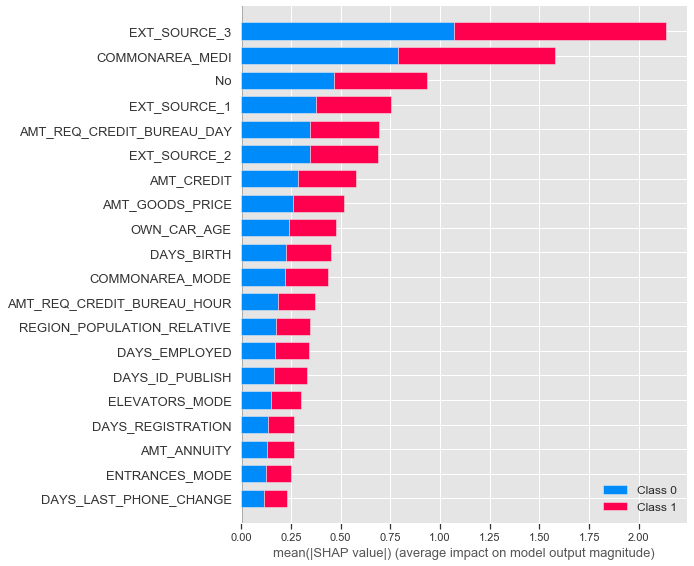

In [48]:
shap.summary_plot(shap_values, X_validation)

In [50]:
# Tree Explainer with SHAP.
explainer = shap.TreeExplainer(grid_search_lgbm_undersampled.best_estimator_)

In [64]:
# Force plot with SHAP.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_validation.iloc[0,:])